# 주제: 와인 분류하기
- 사용할 데이터 : 08_wine.csv

## 분석 방법

- 스케일링 : 스탠다드 스케일러 사용

- 데이터 분류 : 훈련/검증/테스트 = 6 : 2 : 2로 분류하여 사용

- 하이퍼 파라미터 튜닝 진행

## 튜닝 속성
- HGB : `max_iter = [50, 100]` / `max_depth = [None, 10]` / `min_samples_leaf = [1,2,4]`

- XGB : `n_estimators = [50,100]` / `max_depth = [None, 10]` / `min_child_weight = [1,2,4]`

- 나머지 모델 : `n_estimators = [50,100]` / `max_depth = [None, 10]` / `min_samples_split = [2,5]`/ `min_samples_leaf = [1,2,4]`

- `scoring = accuracy` 사용

- `cv = 5` 사용

- refit은 사용 안해도 됨



## <최종결과>
- 데이터프레임에 담아서 출력

    - 컬럼명 : 모델명, 훈련 정확도, 검증 정확도, (훈련 - 검증 정확도), 정밀도, 재현율, F1-Score
 
- 최종모델 선정 후

    - 테스트 정확도, 정밀도, 재현율, F1-Score 확인

# 1. 데이터 확인 및 전처리

In [1]:
### 사용할 라이브러리
# - 데이터 처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = True

# - 데이터 분류, 하이퍼 파라미터 튜닝
from sklearn.model_selection import train_test_split, GridSearchCV

# - 분류 모덷
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

# - 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# - 오차행렬
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
wine = pd.read_csv('./data/08_wine.csv')
wine

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0
...,...,...,...,...
6492,11.2,1.6,3.27,1.0
6493,9.6,8.0,3.15,1.0
6494,9.4,1.2,2.99,1.0
6495,12.8,1.1,3.34,1.0


In [3]:
# 결측치 및 이상치 확인
wine.info()
wine.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [4]:
# 독립 변수 및 종속 변수 분리
data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

data.shape, target.shape

((6497, 3), (6497,))

In [5]:
# 훈련 및 검증 및 테스트 데이터로 분리
X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp, test_size=0.5, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3898, 3), (3898,), (1299, 3), (1299,), (1300, 3), (1300,))

In [6]:
# 데이터 스케일링
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((3898, 3), (1299, 3), (1300, 3))

# 2. 기본 모델

In [7]:
# 모델 생성하기
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
model_list = [rf, hgb, xgb, et, gb]

In [8]:
# 훈련 시키는 함수 만들기
def getTrain(model, train_input, train_target, val_input, val_target):
    model.fit(train_input, train_target)

    # train
    train_pred =  model.predict(train_input)
    train_acc = accuracy_score(train_target, train_pred)
    train_pre = precision_score(train_target, train_pred)
    train_rec = recall_score(train_target, train_pred
    train_f1 = f1_score(train_target, train_pred)

    # val
    val_pred = model.predict(val_input)
    val_acc = accuracy_score(val_target, val_pred)
    val_pre = precision_score(val_target, val_pred)
    val_rec = recall_score(val_target, val_pred)
    val_f1 = f1_score(val_target, val_pred)

    return model, train_acc, val_acc, train_pre, train_rec, train_f1, val_pre, val_rec, val_f1

In [9]:
dict_model = {}
rs_df =pd.DataFrame()
for m in model_list:
    model_name = m.__class__.__name__
    dict_model[model_name] = getTrain(m,X_train,y_train, X_val, y_val)
    model, train_acc, val_acc, train_pre, train_rec, train_f1, val_pre, val_rec, val_f1= getTrain(m, X_train, y_train, X_val, y_val)
    rs_temp = pd.DataFrame([[model_name, train_acc, val_acc, train_acc-val_acc, train_pre, train_rec, train_f1, val_pre, val_rec, val_f1]],
                          columns=['model_name',  'train_acc', 'val_acc', 'train_acc-val_acc', 
                                   'train_pre', 'train_rec','train_f1', 'val_pre', 'val_rec','val_f1'])
   

    ### 원본 데이터프레임에 rs_temp 데이터를 행 단위로 추가하
    rs_df = pd.concat([rs_df,rs_temp],ignore_index=True)
rs_df

,model_name,train_acc,val_acc,train_acc-val_acc,train_pre,train_rec,train_f1,val_pre,val_rec,val_f1
0,RandomForestClassifier,0.997435,0.884527,0.112908,0.997652,0.998992,0.998322,0.926272,0.918641,0.922441
1,HistGradientBoostingClassifier,0.940226,0.876828,0.063397,0.963514,0.958011,0.960755,0.928194,0.905252,0.916580
2,XGBClassifier,0.959979,0.872209,0.087770,0.972213,0.975479,0.973843,0.922350,0.905252,0.913721
3,ExtraTreesClassifier,0.997435,0.886066,0.111368,0.999663,0.996977,0.998318,0.920327,0.927909,0.924103
4,GradientBoostingClassifier,0.891739,0.864511,0.027228,0.922593,0.936849,0.929667,0.911917,0.906282,0.909091


#### 해석 

- RandomForestClassifier와 ExtraTreesClassifier는 과대 적합이 일어나기 때문에 사용하기 적절치 못하다.

- 훈련 정확도와 검증 정확도 차이가 가장 적은 GradientBoostingClassifier가 가장 일반화된 모델이라고 생각한다.

# 3. 하이퍼 파라미터 튜닝

In [13]:
# 하이퍼 파라미터 튜닝
def hypeBoy(model, gridParams, scoring, train_input, train_target, val_input, val_target, cv=5, n_jobs=-1):
    
    grid_search_model = GridSearchCV(model, gridParams, scoring=scoring, cv=cv, n_jobs=n_jobs)
    
    grid_search_model.fit(train_input,train_target)
    best_model = grid_search_model.best_estimator_
    
    # train
    train_pred = best_model.predict(train_input)
    train_acc = accuracy_score(train_target, train_pred)
    train_pre = precision_score(train_target, train_pred)
    train_rec = recall_score(train_target, train_pred)
    
    # val
    train_f1 = f1_score(train_target, train_pred)
    val_pred = best_model.predict(val_input)
    val_pre = precision_score(val_target, val_pred)
    val_rec = recall_score(val_target, val_pred)
    val_f1 = f1_score(val_target, val_pred)

    return best_model, train_acc, val_acc, train_pre, train_rec, train_f1, val_pre, val_rec, val_f1

In [14]:
tuning_df = pd.DataFrame()
dict_tuning ={}
for m in model_list:
    model_name = m.__class__.__name__
    gridParams = {}
    
    if model_name == 'RandomForestClassifier':
        gridParams['n_estimators'] = [50, 100]
        gridParams['max_depth'] = [None, 10]
        gridParams['min_samples_split'] = [2,5]
        

    elif model_name == 'XGBClassifier':
        gridParams['n_estimators'] = [50, 100]
        gridParams['max_depth'] = [None, 10]
        gridParams['min_child_weight'] = [1,2,4]
        
    elif model_name == 'HistGradientBoostingClassifier':
        gridParams['max_depth'] = [None, 10]
        gridParams['min_samples_leaf'] = [1,2,4]
        
    elif model_name == 'ExtraTreesClassifier':
        gridParams['n_estimators'] = [50, 100]
        gridParams['max_depth'] = [None, 10]
        gridParams['min_samples_split'] = [2,5]
        
    else:
        gridParams['n_estimators'] = [50, 100]
        gridParams['max_depth'] = [None, 10]
        gridParams['min_samples_split'] = [2,5]


    scoring = 'accuracy'

    print(model_name, gridParams)
    
    best_model, train_acc, val_acc, train_pre, train_rec, train_f1, val_pre, val_rec, val_f1 = hypeBoy(m, gridParams, scoring, X_train_scaled, y_train, X_val_scaled, y_val)
    dict_tuning[model_name] = best_model, train_acc, val_acc, train_pre, train_rec, train_f1, val_pre, val_rec, val_f1
    rs_temp2 = pd.DataFrame([[model_name, train_acc, val_acc, train_acc - val_acc, train_pre, train_rec, train_f1, val_pre, val_rec, val_f1]],
                          columns=['model_name', 'train_acc', 'val_acc', 'train_acc-val_acc', 'train_pre', 'train_rec','train_f1','val_pre', 'val_rec','val_f1'])
   

    ### 원본 데이터프레임에 rs_temp 데이터를 행 단위로 추가하
    tuning_df = pd.concat([tuning_df,rs_temp2],ignore_index=True)
    
tuning_df


RandomForestClassifier {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
HistGradientBoostingClassifier {'max_depth': [None, 10], 'min_samples_leaf': [1, 2, 4]}
XGBClassifier {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_child_weight': [1, 2, 4]}
ExtraTreesClassifier {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
GradientBoostingClassifier {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}


,model_name,train_acc,val_acc,train_acc-val_acc,train_pre,train_rec,train_f1,val_pre,val_rec,val_f1
0,RandomForestClassifier,0.997435,0.864511,0.132923,0.997652,0.998992,0.998322,0.927310,0.919670,0.923475
1,HistGradientBoostingClassifier,0.950744,0.864511,0.086233,0.974770,0.960363,0.967513,0.924528,0.908342,0.916364
2,XGBClassifier,0.974859,0.864511,0.110348,0.982245,0.984884,0.983563,0.917355,0.914521,0.915936
3,ExtraTreesClassifier,0.979220,0.864511,0.114709,0.980106,0.992946,0.986484,0.907738,0.942327,0.924709
4,GradientBoostingClassifier,0.997435,0.864511,0.132923,0.997986,0.998656,0.998321,0.922756,0.910402,0.916537


#### 해석

- RandomForestClassifier, XGBClassifier, GradientBoostingClassifier, ExtraTreesClassifier는 과대 적합이 일어나기 때문에 사용하기 적절치 못하다

- 그래서 과대 적합이 일어나지 않은 모델인 HistGradientBoostingClassifier이 가장 일반화된 모델이기 때문에 선정하였다.

In [15]:
test_pred = dict_tuning['HistGradientBoostingClassifier'][0].predict(X_test_scaled)

acc = accuracy_score(y_test, test_pred)
pre = precision_score(y_test, test_pred)
rec = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)

print(f'acc = {acc} / pre = {pre} / rec={rec} / f1={f1}')

acc = 0.8592307692307692 / pre = 0.9101604278074866 / rec=0.8957894736842106 / f1=0.9029177718832891


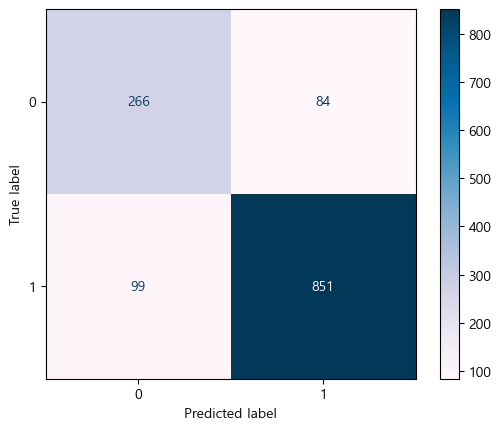

In [18]:
cm = confusion_matrix(y_test,test_pred)
dist = ConfusionMatrixDisplay(cm)
dist.plot(cmap='PuBu');